## Time Series

The goal of the project is to build a model that predicts  the amount of taxi orders for the next hour.  

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.index.is_monotonic

True

Dates and times are in chronological order.

Let's plot the time series graph.

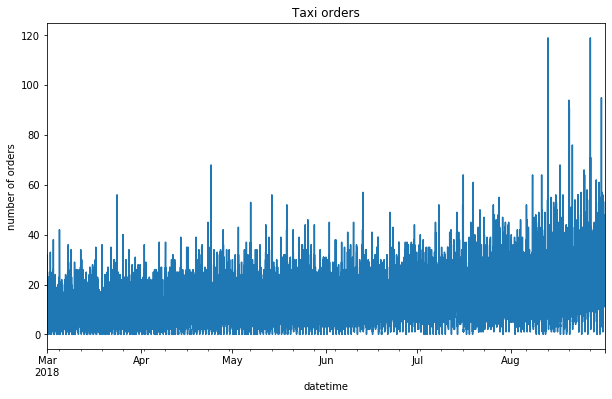

In [4]:
ax = data.plot(figsize = (10,6), title = "Taxi orders", legend = False);
ax.set_xlabel('datetime');
ax.set_ylabel ('number of orders');

Let's resample the data by one hour and calculate the total orders for each hour.

In [5]:
data = data.resample('1H').sum()

Now we'll look into trends and seasonality.

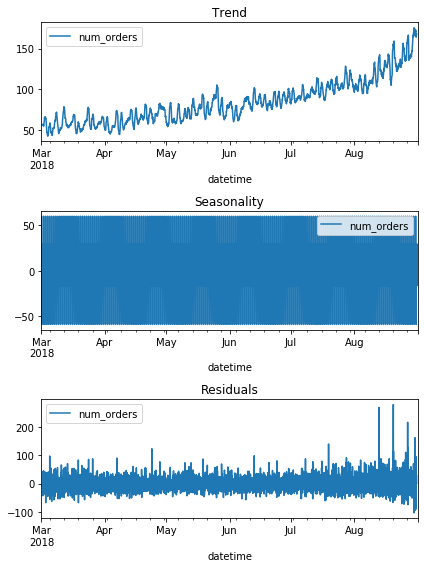

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(3,1,1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(3,1,2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(3,1,3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Let's plot a graph of the seasonal component for the first day of March.

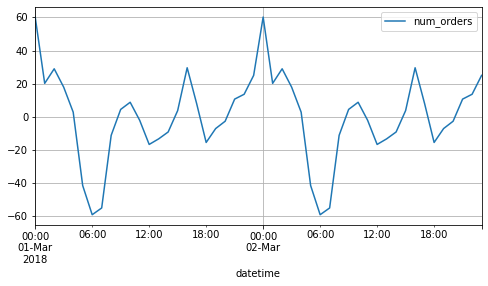

In [7]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), figsize = (8,4), grid = True);


Trend: we can see that the number of orders was growing over time.

Seasonality: the number of orders is decreasing from 0:00 till 6:00, there are three peaks: at about 10:00, 17:00 and 0:00.

Let's create new features: calendar features, lag features, rolling mean.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Now we'll train different models and look at RMSE. Let's set max_lag = 24 and rolling_mean_size = 6 (hours) 

In [9]:
make_features(data, 24, 6)

In [10]:
# split data into train (90%) and test (10%) sets
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders'] 


* Linear Regression

In [11]:
model_LR = LinearRegression()

model_LR.fit(features_train, target_train)
pred_train_LR = model_LR.predict(features_train)
pred_test_LR = model_LR.predict(features_test)

rmse_train_LR = mean_squared_error(target_train, pred_train_LR)**0.5
rmse_test_LR = mean_squared_error(target_test, pred_test_LR)**0.5

print("RMSE for the training set:", rmse_train_LR)
print("RMSE for the test set: ", rmse_test_LR)

RMSE for the training set: 25.818602103995378
RMSE for the test set:  45.529337080209345


* Random Forest

In [12]:
model_RF = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state=12345)

model_RF.fit(features_train, target_train)

pred_train_RF = model_RF.predict(features_train)
pred_test_RF = model_RF.predict(features_test)

rmse_train_RF = mean_squared_error(target_train, pred_train_RF)**0.5
rmse_test_RF = mean_squared_error(target_test, pred_test_RF)**0.5

print("RMSE for the training set:", rmse_train_RF)
print("RMSE for the test set: ", rmse_test_RF)


RMSE for the training set: 14.434538145678763
RMSE for the test set:  43.11629029768597


* CatBoost

In [13]:
model_CB = CatBoostRegressor()

parameters = {'depth'         : [6,10],
              'learning_rate' : [0.03, 0.1],
              'n_estimators'  : [60,100] }

tscv = TimeSeriesSplit(n_splits=2)

randm = RandomizedSearchCV(estimator=model_CB, param_distributions = parameters, scoring='neg_mean_squared_error',  
                               cv = tscv, n_iter = 10, n_jobs=-1, verbose = 2, random_state=12345)

randm_results=randm.fit(features_train, target_train)


print("\n The best score:\n ", randm_results.best_score_)

print("\n The best parameters:\n ", randm_results.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
pred_train_CB = randm.predict(features_train)
pred_test_CB = randm.predict(features_test)
  
rmse_train_CB = mean_squared_error(target_train, pred_train_CB)**0.5
rmse_test_CB = mean_squared_error(target_test, pred_test_CB)**0.5

print("RMSE for the training set:", rmse_train_CB)
print("RMSE for the test set: ", rmse_test_CB)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 29.9313562	total: 52ms	remaining: 3.07s
1:	learn: 29.5525413	total: 54.8ms	remaining: 1.59s
2:	learn: 29.1757965	total: 58.1ms	remaining: 1.1s
3:	learn: 28.8231215	total: 62.1ms	remaining: 870ms
4:	learn: 28.4917807	total: 67.4ms	remaining: 741ms
5:	learn: 28.1883141	total: 73.4ms	remaining: 660ms
6:	learn: 27.9030220	total: 80.8ms	remaining: 611ms
7:	learn: 27.6063210	total: 158ms	remaining: 1.03s
8:	learn: 27.3328783	total: 163ms	remaining: 923ms
9:	learn: 27.0607852	total: 172ms	remaining: 858ms
10:	learn: 26.7818852	total: 178ms	remaining: 792ms
11:	learn: 26.4977931	total: 181ms	remaining: 724ms
12:	learn: 26.2424618	total: 255ms	remaining: 923ms
13:	learn: 25.9840238	total: 259ms	remaining: 851ms
14:	learn: 25.7306764	total: 263ms	remaining: 789ms
15:	learn: 25.4674527	total: 270ms	remaining: 743ms
16:	learn: 25.2373958	total: 351ms	remaining: 888ms
17:	learn: 25.0007752	total: 355ms	remaining: 829ms
18:	learn: 24.8111284	total: 361ms	remaining: 780ms
19:	learn: 24.5772

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


0:	learn: 32.9390918	total: 7.19ms	remaining: 424ms
1:	learn: 32.5193035	total: 12.8ms	remaining: 370ms
2:	learn: 32.1028687	total: 33ms	remaining: 627ms
3:	learn: 31.7148407	total: 46.2ms	remaining: 647ms
4:	learn: 31.3503566	total: 129ms	remaining: 1.42s
5:	learn: 30.9771581	total: 140ms	remaining: 1.26s
6:	learn: 30.6205919	total: 146ms	remaining: 1.1s
7:	learn: 30.2765146	total: 230ms	remaining: 1.49s
8:	learn: 29.9254494	total: 244ms	remaining: 1.38s
9:	learn: 29.6315141	total: 318ms	remaining: 1.59s
10:	learn: 29.2979628	total: 329ms	remaining: 1.47s
11:	learn: 28.9838148	total: 342ms	remaining: 1.37s
12:	learn: 28.6705078	total: 426ms	remaining: 1.54s
13:	learn: 28.3847938	total: 438ms	remaining: 1.44s
14:	learn: 28.1176020	total: 523ms	remaining: 1.57s
15:	learn: 27.8724351	total: 534ms	remaining: 1.47s
16:	learn: 27.6181531	total: 615ms	remaining: 1.55s
17:	learn: 27.3832638	total: 628ms	remaining: 1.47s
18:	learn: 27.1500522	total: 708ms	remaining: 1.53s
19:	learn: 26.9087864

[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   4.1s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
0:	learn: 32.9390918	total: 8.69ms	remaining: 860ms
1:	learn: 32.5193035	total: 21.1ms	remaining: 1.03s
2:	learn: 32.1028687	total: 108ms	remaining: 3.5s
3:	learn: 31.7148407	total: 122ms	remaining: 2.92s
4:	learn: 31.3503566	total: 207ms	remaining: 3.92s
5:	learn: 30.9771581	total: 221ms	remaining: 3.46s
6:	learn: 30.6205919	total: 232ms	remaining: 3.09s
7:	learn: 30.2765146	total: 307ms	remaining: 3.53s
8:	learn: 29.9254494	total: 321ms	remaining: 3.24s
9:	learn: 29.6315141	total: 406ms	remaining: 3.65s
10:	learn: 29.2979628	total: 420ms	remaining: 3.4s
11:	learn: 28.9838148	total: 499ms	remaining: 3.66s
12:	learn: 28.6705078	total: 513ms	remaining: 3.43s
13:	learn: 28.3847938	total: 597ms	remaining: 3.67s
14:	learn: 28.1176020	total: 615ms	remaining: 3.49s
15:	learn: 27.8724351	total: 696ms	remaining: 3.65s
16:	learn: 27.6181531	total: 707ms	r

[CV] ...... n_estimators=60, learning_rate=0.1, depth=6, total=   2.8s
[CV] n_estimators=60, learning_rate=0.1, depth=6 .....................
0:	learn: 31.9264765	total: 10.5ms	remaining: 619ms
1:	learn: 30.6970189	total: 21.2ms	remaining: 615ms
2:	learn: 29.5235524	total: 99.4ms	remaining: 1.89s
3:	learn: 28.5110923	total: 110ms	remaining: 1.54s
4:	learn: 27.6932080	total: 123ms	remaining: 1.36s
5:	learn: 26.8762909	total: 202ms	remaining: 1.82s
6:	learn: 26.2114999	total: 217ms	remaining: 1.65s
7:	learn: 25.5893986	total: 224ms	remaining: 1.45s
8:	learn: 25.0408632	total: 302ms	remaining: 1.71s
9:	learn: 24.5647248	total: 316ms	remaining: 1.58s
10:	learn: 24.0423090	total: 398ms	remaining: 1.77s
11:	learn: 23.6874747	total: 409ms	remaining: 1.64s
12:	learn: 23.3228760	total: 493ms	remaining: 1.78s
13:	learn: 22.9771063	total: 506ms	remaining: 1.66s
14:	learn: 22.7210662	total: 517ms	remaining: 1.55s
15:	learn: 22.4899250	total: 597ms	remaining: 1.64s
16:	learn: 22.2284276	total: 608m

98:	learn: 13.7220589	total: 2.07s	remaining: 20.9ms
99:	learn: 13.6512594	total: 2.16s	remaining: 0us
[CV] ..... n_estimators=100, learning_rate=0.1, depth=6, total=   3.8s
[CV] n_estimators=100, learning_rate=0.1, depth=6 ....................
0:	learn: 31.9264765	total: 5.85ms	remaining: 579ms
1:	learn: 30.6970189	total: 12.3ms	remaining: 604ms
2:	learn: 29.5235524	total: 33.1ms	remaining: 1.07s
3:	learn: 28.5110923	total: 113ms	remaining: 2.71s
4:	learn: 27.6932080	total: 123ms	remaining: 2.34s
5:	learn: 26.8762909	total: 133ms	remaining: 2.09s
6:	learn: 26.2114999	total: 143ms	remaining: 1.9s
7:	learn: 25.5893986	total: 225ms	remaining: 2.59s
8:	learn: 25.0408632	total: 236ms	remaining: 2.38s
9:	learn: 24.5647248	total: 313ms	remaining: 2.82s
10:	learn: 24.0423090	total: 323ms	remaining: 2.61s
11:	learn: 23.6874747	total: 414ms	remaining: 3.04s
12:	learn: 23.3228760	total: 504ms	remaining: 3.38s
13:	learn: 22.9771063	total: 512ms	remaining: 3.14s
14:	learn: 22.7210662	total: 521ms	

53:	learn: 18.7074008	total: 5.89s	remaining: 654ms
54:	learn: 18.6041463	total: 5.98s	remaining: 544ms
55:	learn: 18.4948850	total: 6.08s	remaining: 434ms
56:	learn: 18.3678139	total: 6.2s	remaining: 326ms
57:	learn: 18.2486739	total: 6.29s	remaining: 217ms
58:	learn: 18.1331831	total: 6.38s	remaining: 108ms
59:	learn: 18.0178638	total: 6.49s	remaining: 0us
[CV] .... n_estimators=60, learning_rate=0.03, depth=10, total=   8.3s
[CV] n_estimators=60, learning_rate=0.03, depth=10 ...................
0:	learn: 32.9249212	total: 36.1ms	remaining: 2.13s
1:	learn: 32.4761792	total: 215ms	remaining: 6.24s
2:	learn: 32.0362862	total: 330ms	remaining: 6.26s
3:	learn: 31.6461032	total: 518ms	remaining: 7.25s
4:	learn: 31.2679913	total: 626ms	remaining: 6.89s
5:	learn: 30.8656728	total: 813ms	remaining: 7.32s
6:	learn: 30.5008612	total: 927ms	remaining: 7.02s
7:	learn: 30.1400195	total: 1.03s	remaining: 6.72s
8:	learn: 29.7772320	total: 1.22s	remaining: 6.89s
9:	learn: 29.4339215	total: 1.33s	rem

87:	learn: 15.5911292	total: 9.45s	remaining: 1.29s
88:	learn: 15.5371760	total: 9.55s	remaining: 1.18s
89:	learn: 15.4717496	total: 9.67s	remaining: 1.07s
90:	learn: 15.4001001	total: 9.74s	remaining: 964ms
91:	learn: 15.3273311	total: 9.84s	remaining: 856ms
92:	learn: 15.2545107	total: 9.95s	remaining: 749ms
93:	learn: 15.1941508	total: 10s	remaining: 641ms
94:	learn: 15.1234324	total: 10.1s	remaining: 534ms
95:	learn: 15.0529519	total: 10.2s	remaining: 427ms
96:	learn: 14.9953204	total: 10.4s	remaining: 321ms
97:	learn: 14.9395360	total: 10.5s	remaining: 214ms
98:	learn: 14.8594461	total: 10.6s	remaining: 108ms
99:	learn: 14.8169252	total: 10.7s	remaining: 0us
[CV] ... n_estimators=100, learning_rate=0.03, depth=10, total=  12.6s
[CV] n_estimators=100, learning_rate=0.03, depth=10 ..................
0:	learn: 32.9249212	total: 87.3ms	remaining: 8.64s
1:	learn: 32.4761792	total: 191ms	remaining: 9.34s
2:	learn: 32.0362862	total: 313ms	remaining: 10.1s
3:	learn: 31.6461032	total: 477m

41:	learn: 12.7165986	total: 4.63s	remaining: 1.98s
42:	learn: 12.6191081	total: 4.72s	remaining: 1.87s
43:	learn: 12.4416995	total: 4.83s	remaining: 1.75s
44:	learn: 12.2318778	total: 4.93s	remaining: 1.65s
45:	learn: 12.1529826	total: 5.04s	remaining: 1.53s
46:	learn: 12.0095561	total: 5.13s	remaining: 1.42s
47:	learn: 11.8659201	total: 5.32s	remaining: 1.33s
48:	learn: 11.7528183	total: 5.42s	remaining: 1.22s
49:	learn: 11.6297662	total: 5.52s	remaining: 1.1s
50:	learn: 11.4831227	total: 5.61s	remaining: 990ms
51:	learn: 11.4290983	total: 5.71s	remaining: 879ms
52:	learn: 11.2828747	total: 5.82s	remaining: 768ms
53:	learn: 11.2176031	total: 5.91s	remaining: 657ms
54:	learn: 11.1204458	total: 6.01s	remaining: 547ms
55:	learn: 10.9577522	total: 6.12s	remaining: 437ms
56:	learn: 10.8260777	total: 6.22s	remaining: 327ms
57:	learn: 10.7300756	total: 6.33s	remaining: 218ms
58:	learn: 10.6433743	total: 6.43s	remaining: 109ms
59:	learn: 10.4930615	total: 6.61s	remaining: 0us
[CV] ..... n_es

77:	learn: 8.9767595	total: 8.69s	remaining: 2.45s
78:	learn: 8.9072589	total: 8.79s	remaining: 2.34s
79:	learn: 8.8586423	total: 8.9s	remaining: 2.23s
80:	learn: 8.7422266	total: 8.99s	remaining: 2.11s
81:	learn: 8.7173236	total: 9.1s	remaining: 2s
82:	learn: 8.6237472	total: 9.21s	remaining: 1.89s
83:	learn: 8.5395607	total: 9.32s	remaining: 1.77s
84:	learn: 8.4544211	total: 9.49s	remaining: 1.67s
85:	learn: 8.3507378	total: 9.52s	remaining: 1.55s
86:	learn: 8.2918568	total: 9.68s	remaining: 1.45s
87:	learn: 8.2044020	total: 9.79s	remaining: 1.33s
88:	learn: 8.0653636	total: 9.89s	remaining: 1.22s
89:	learn: 8.0314663	total: 9.98s	remaining: 1.11s
90:	learn: 7.9701923	total: 10.1s	remaining: 998ms
91:	learn: 7.8942933	total: 10.2s	remaining: 887ms
92:	learn: 7.8886671	total: 10.3s	remaining: 775ms
93:	learn: 7.7709353	total: 10.4s	remaining: 664ms
94:	learn: 7.6921590	total: 10.6s	remaining: 557ms
95:	learn: 7.6151321	total: 10.7s	remaining: 445ms
96:	learn: 7.5169831	total: 10.8s	re

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


0:	learn: 36.9537309	total: 3.89ms	remaining: 385ms
1:	learn: 35.4228186	total: 7.14ms	remaining: 350ms
2:	learn: 34.1187453	total: 10.4ms	remaining: 337ms
3:	learn: 32.9368770	total: 24.7ms	remaining: 593ms
4:	learn: 31.8050582	total: 31.3ms	remaining: 595ms
5:	learn: 30.8785066	total: 110ms	remaining: 1.73s
6:	learn: 30.0887064	total: 131ms	remaining: 1.74s
7:	learn: 29.3951019	total: 209ms	remaining: 2.4s
8:	learn: 28.8199560	total: 226ms	remaining: 2.29s
9:	learn: 28.2545070	total: 309ms	remaining: 2.78s
10:	learn: 27.7715056	total: 323ms	remaining: 2.61s
11:	learn: 27.3499031	total: 336ms	remaining: 2.46s
12:	learn: 26.9579680	total: 411ms	remaining: 2.75s
13:	learn: 26.5953792	total: 417ms	remaining: 2.56s
14:	learn: 26.2721247	total: 508ms	remaining: 2.88s
15:	learn: 26.0014142	total: 518ms	remaining: 2.72s
16:	learn: 25.7618779	total: 607ms	remaining: 2.96s
17:	learn: 25.5028833	total: 618ms	remaining: 2.81s
18:	learn: 25.2969259	total: 708ms	remaining: 3.02s
19:	learn: 25.0916

* LightGBM

In [14]:
lgbm_model = lgb.LGBMRegressor()

parameters = {'depth'         : [6,10],
              'learning_rate' : [0.03, 0.1],
              'n_estimators'  : [60,100] }

tscv = TimeSeriesSplit(n_splits=2)

randm = RandomizedSearchCV(estimator=lgbm_model, param_distributions = parameters, scoring='neg_mean_squared_error',  
                               cv = tscv, n_iter = 10, n_jobs=-1, verbose = 2, random_state=12345)

randm_results=randm.fit(features_train, target_train)


print("\n The best score:\n ", randm_results.best_score_)

print("\n The best parameters:\n ", randm_results.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
pred_train_LGBM = randm.predict(features_train)
pred_test_LGBM = randm.predict(features_test)
  
rmse_train_LGBM = mean_squared_error(target_train, pred_train_LGBM)**0.5
rmse_test_LGBM = mean_squared_error(target_test, pred_test_LGBM)**0.5

print("RMSE for the training set:", rmse_train_LGBM)
print("RMSE for the test set: ", rmse_test_LGBM)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.8s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   1.2s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   1.7s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   1.7s
[CV] n_estimators=60, learning_rate=0.1, depth=6 .....................
[CV] ...... n_estimators=60, learning_rate=0.1, depth=6, total=   0.9s
[CV] n_estimators=60, learning_rate=0.1, depth=6 .....................
[CV] ...... n_estimators=60, learning_rate=0.1, depth=6, total=   0.9s
[CV] n_estimators=100, learning_rate=0.1, depth=6 ....................
[CV] ..... n_estimators=100, learning_rate=0.1, depth=6, total=   1.5s
[CV] n_estimators=100, learning_rate=0.1, depth=6 ....................
[CV] ..... n_estimators=100, learning_rate=0.1, depth=6, total=   1.5s
[CV] n_estimators=60, learning_rate=0.03, depth=10 ...................
[CV] .

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished



 The best score:
  -791.3120029453975

 The best parameters:
  {'n_estimators': 60, 'learning_rate': 0.1, 'depth': 6}
RMSE for the training set: 15.343034971662115
RMSE for the test set:  42.16057150059529


Let's write a function that calculates rolling mean for prediction and actual values and plot four graphs: real values, predictions and two rolling means.

n - rolling window size

In [15]:
def plot_roll_avg(prediction, target, n, rmse):
    
    pred = pd.Series(prediction, index = target.index)

    pred_rol = pred.rolling(n).mean()

    target_rol = target.rolling(n).mean()
    
    df = pd.DataFrame({
      'real values' : target,
      'prediction' : pred,
      'prediction rolling average' : pred_rol,
      'real rolling average' : target_rol
     })
    
    df.plot(figsize=(15,5))
    plt.title("Rolling average with window size = {} and RMSE for test set = {}".format(n, round(rmse,2)))

* Linear Regression

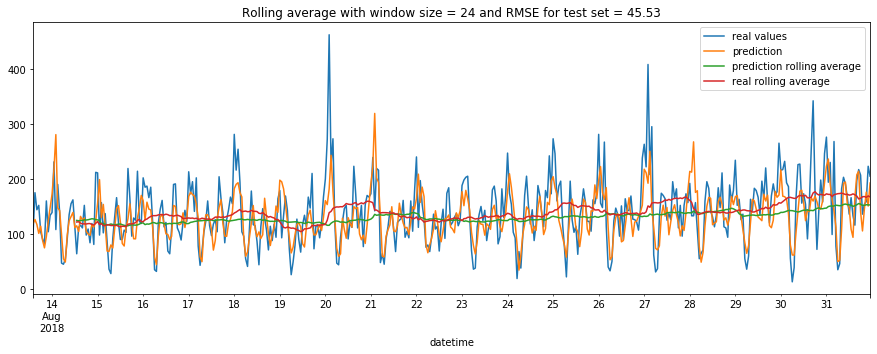

In [16]:
plot_roll_avg(pred_test_LR, target_test, 24, rmse_test_LR)

* Random Forest

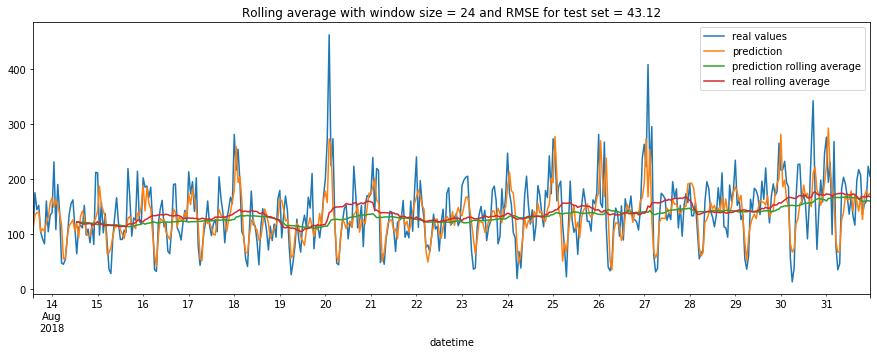

In [17]:
plot_roll_avg(pred_test_RF, target_test, 24, rmse_test_RF)

* CatBoost

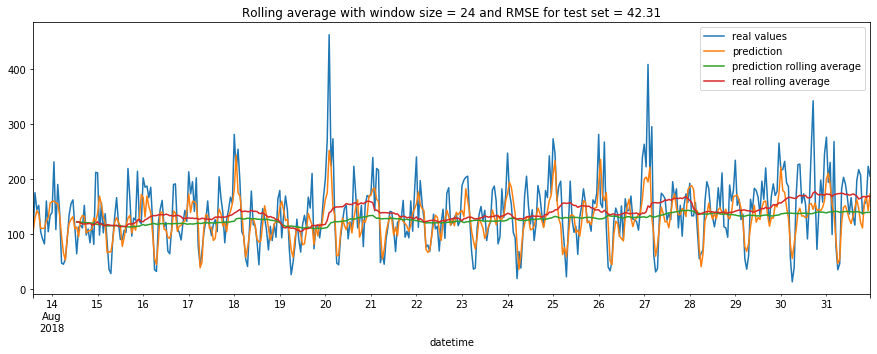

In [18]:
plot_roll_avg(pred_test_CB, target_test, 24, rmse_test_CB)

* LightGBM

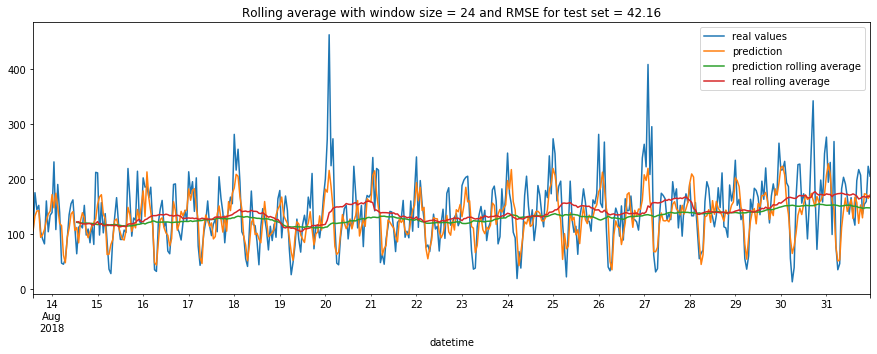

In [19]:
plot_roll_avg(pred_test_LGBM, target_test, 24, rmse_test_LGBM)

#### CatBoost and LightGBM have very similar RMSE. Two other models (Linear Regression and Random Forest) have bigger error.

#### So, we conclude that both models CatBoost and LightGBM are good for predicting the amount of taxi orders for the next hour.
